In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from skimage.data import shepp_logan_phantom
from skimage.transform import resize,radon,iradon
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.transform import radon, iradon

In [58]:
def zero_outside_circle(img):
    n = img.shape[0]
    y, x = np.ogrid[:n, :n]
    center = (n - 1) / 2.0
    mask = (x - center)**2 + (y - center)**2 <= center**2
    img[~mask] = 0
    return img

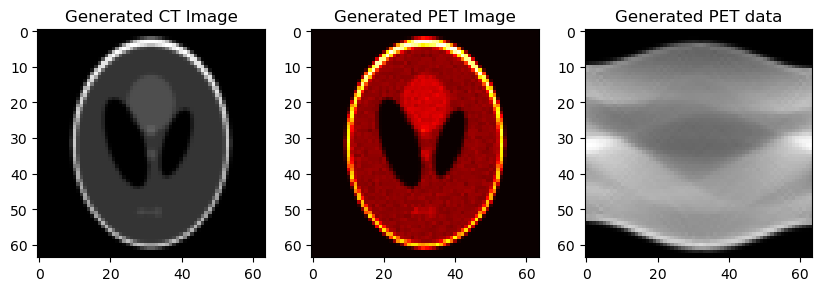

In [60]:
# Get CT and PET images based on Shepp-Logan
def generate_shepp_logan_data(shape=(64,64)):
    base_phantom = resize(shepp_logan_phantom(), shape, mode='reflect', anti_aliasing=True)
    anat_phantom = base_phantom #Use origincal phantom as anotomical phantom
    #Rescale and add noise to get emission model
    max_val = np.max(anat_phantom)
    scale_factor = 1000.0 / max_val
    emission_distribution = anat_phantom * scale_factor #Rescale
    # emission_distribution += 100.0 #Add background value
    emission_phantom = np.random.poisson(emission_distribution).astype(float)
    return  anat_phantom,  emission_phantom
    
anat_phantom, emission_phantom = generate_shepp_logan_data()
shape = emission_phantom.shape
angles = np.linspace(0., 180., max(shape), endpoint=False)
pet_data = radon(zero_outside_circle(emission_phantom), theta=angles, circle=True)
# visualization
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(anat_phantom, cmap='gray')
axes[0].set_title("Generated CT Image")
axes[1].imshow(emission_phantom, cmap='hot')
axes[1].set_title("Generated PET Image")
axes[2].imshow(pet_data, cmap='gray')
axes[2].set_title("Generated PET data")
plt.show()

In [62]:
# Bowsher weighted function
def psi(u, zeta=0.5, rho=0.01):
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5
    
def bowsher_weights(anat_phantom, voxel, neighbors,zeta=0.5, rho=0.01,epsilon=1e-6):
    central_value = anat_phantom[voxel]
    neighbor_values = np.array([anat_phantom[n] for n in neighbors])
    
    Mj = np.max(np.abs(central_value - neighbor_values))
    Mk_values = [np.max(np.abs(anat_phantom[n] - neighbor_values)) for n in neighbors]
    
    denominator = (Mj + np.array(Mk_values)) / 2
    denominator = np.maximum(denominator, epsilon)
    
    weights = psi(np.abs(central_value - neighbor_values) / denominator, zeta, rho)
    return weights / np.sum(weights)
    
#test
# if __name__ == "__main__":
#     anat_phantom = np.random.rand(64, 64)
    
#     voxel = (32, 32)
#     neighbors = [(31, 31), (31, 32), (31, 33), (32, 31), (32, 33), (33, 31), (33, 32), (33, 33)]
    
#     weights = bowsher_weights(anat_phantom, voxel, neighbors)
#     print("Computed Bowsher Weights:", weights)
#     print("Sum of Weights (should be 1):", np.sum(weights))

In [64]:
# MAP objective function
def map_objective(emission_phantom, pet_data, regularization):
    emission_phantom = emission_phantom.reshape(shape)
    estimated_pet = radon(zero_outside_circle(emission_phantom), theta=angles, circle=True)
    likelihood = np.sum(pet_data * np.log(estimated_pet + 1e-6) - estimated_pet)
    prior = regularization
    return -likelihood + prior

In [66]:
# Anatomical information regularization term
def anatomical_regularization(parameters, anat_phantom, shape, alpha=0.1, beta=1.0):
    penalty = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            voxel = (i, j)
            neighbors = get_neighbors(voxel, shape)
            weights = bowsher_weights(anat_phantom, voxel, neighbors, beta)
            voxel_value = parameters[voxel]
            neighbor_values = np.array([parameters[neighbor] for neighbor in neighbors])
            penalty += alpha * np.sum(weights * (voxel_value - neighbor_values) ** 2)
    return penalty


In [68]:
# Get 8 neighbor voxels  
def get_neighbors(voxel, shape):
    x, y = voxel
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < shape[0] and 0 <= ny < shape[1]:
                neighbors.append((nx, ny))
    return neighbors

In [48]:
# Optimization
def optimize_parameters(pet_data, anat_phantom, shape, alpha=0.1, beta=1.0):
    initial_params = np.ones(shape).flatten()
    iteration_counter = {'count': 0} 
    #Surrogate Function
    def objective(params):
        params_reshaped = params.reshape(shape)
        reg = anatomical_regularization(params_reshaped, anat_phantom, shape, alpha, beta)
        return map_objective(params, pet_data,reg)
    def iteration_callback(x):
        iteration_counter['count'] += 1
        print(f"Iteration {iteration_counter['count']} completed.")
    result = minimize(objective, initial_params, method='L-BFGS-B', options={'disp': True,'maxiter':60})
    return result.x.reshape(shape)

In [50]:
# Evaluate the image's quality
def evaluate_quality(reference, reconstructed):
    data_range = reference.max() - reference.min()
    psnr = peak_signal_noise_ratio(reference, reconstructed,data_range=1.0)
    ssim = structural_similarity(reference, reconstructed,data_range=1.0)
    return psnr, ssim

In [52]:
# Main
if __name__ == "__main__":
    anat_phantom, emission_phantom = generate_shepp_logan_data()
    shape = emission_phantom.shape
    angles = np.linspace(0., 180., max(shape), endpoint=False)
    pet_data = radon(zero_outside_circle(emission_phantom), theta=angles, circle=True)

    estimated_params = optimize_parameters(pet_data, anat_phantom, shape)
    
    # visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("PET Image (Shepp-Logan Phantom)")
    plt.imshow(emission_phantom, cmap='gray')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title("PET Data")
    plt.imshow(pet_data, cmap='hot')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title("Estimated Parameters")
    plt.imshow(estimated_params, cmap='jet')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

In [11]:
    emission_phantom = (emission_phantom - emission_phantom.min()) / (emission_phantom.max() - emission_phantom.min())
    estimated_params = (estimated_params - estimated_params.min()) / (estimated_params.max() - estimated_params.min())
    psnr, ssim = evaluate_quality(emission_phantom,  estimated_params)
    print(psnr, ssim)

5.075405968752334 0.07925097351388537


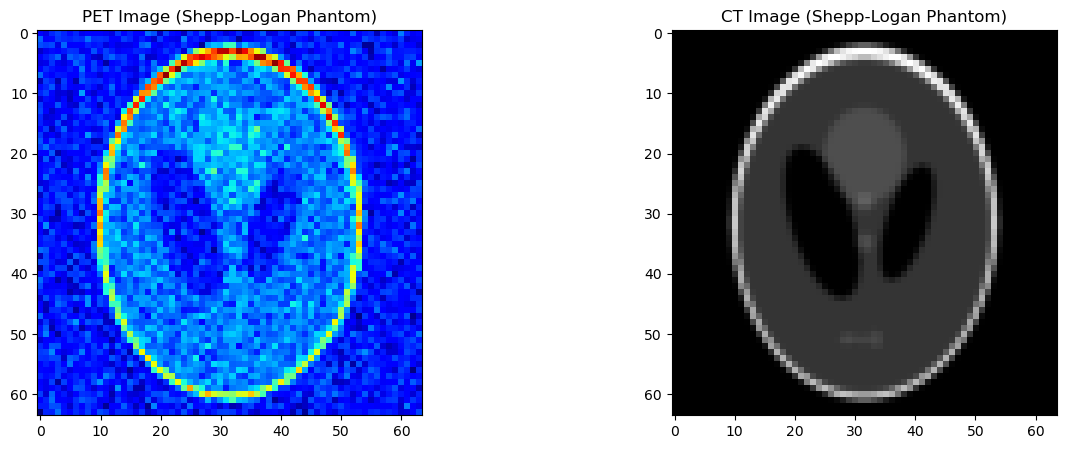

In [12]:
anat_phantom, emission_phantom = generate_shepp_logan_data()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("PET Image (Shepp-Logan Phantom)")
plt.imshow(emission_phantom,cmap='jet')
plt.subplot(1, 2, 2)
plt.title("CT Image (Shepp-Logan Phantom)")
plt.imshow(anat_phantom, cmap='gray')